In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir='/content/drive/MyDrive/Android-App-Skin-Cancer-Detector/Android-App-Skin-Cancer-Detector/Training/Dataset'


In [ ]:
Labels = ['Benign', 'Malignant']

In [ ]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 Benign
1 Malignant


In [ ]:
print('Number of classes:',len(Labels))

Number of classes: 2


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [ ]:
IMAGE_SIZE

(224, 224)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 24 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [ ]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dropout (Dropout)   

In [ ]:
LEARNING_RATE = 0.0005 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(monitor = 'loss', patience = 3)
EPOCHS=50

history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        callbacks= [early_stopping_monitor])

Epoch 1/50
1/1 [==============================] - 24s 24s/step - loss: 0.8284 - accuracy: 0.5000 - val_loss: 0.6324 - val_accuracy: 0.6875
Epoch 2/50
1/1 [==============================] - 1s 640ms/step - loss: 0.7662 - accuracy: 0.3750 - val_loss: 0.6308 - val_accuracy: 0.5625
Epoch 3/50
1/1 [==============================] - 1s 566ms/step - loss: 0.7887 - accuracy: 0.6250 - val_loss: 0.6126 - val_accuracy: 0.6875
Epoch 4/50
1/1 [==============================] - 1s 573ms/step - loss: 0.3061 - accuracy: 0.8750 - val_loss: 0.5684 - val_accuracy: 0.7500
Epoch 5/50
1/1 [==============================] - 1s 615ms/step - loss: 0.3229 - accuracy: 0.8750 - val_loss: 0.5682 - val_accuracy: 0.7500
Epoch 6/50
1/1 [==============================] - 1s 625ms/step - loss: 0.0876 - accuracy: 1.0000 - val_loss: 0.5229 - val_accuracy: 0.7500
Epoch 7/50
1/1 [==============================] - 1s 618ms/step - loss: 0.1997 - accuracy: 0.9375 - val_loss: 0.4710 - val_accuracy: 0.8125
Epoch 8/50
1/1 [=====

ValueError: ignored

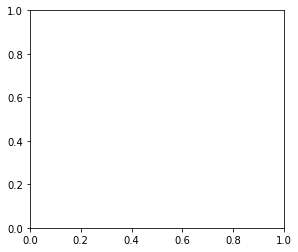

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    
    return {Labels[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 16)

for idx, filename in enumerate(images):
    
    
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [ ]:
cd /content/drive/MyDrive/Buffml/code

#Export as saved model and convert to TFLite

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)

export_path

In [ ]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {Labels[class_idx]: probabilities[class_idx]}

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)